In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings


warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Colors to show wins vs losses.
color_mapping = {"W":"seagreen",
                 "L":"#C8102E"}

sns.set_style("darkgrid")

In [5]:
# We import the data that we will be using for analysis.
playsData = pd.read_csv('../OnlyClippersPlays.csv',index_col=0)
gamesData = pd.read_csv('../ClippersSchedule2425.csv',index_col=0)

In [6]:
# We convert the PLAYED_TIME string column (03:24) into a int column with the seconds played (204)
playsData['PLAYED_TIME'] = pd.to_timedelta(playsData['PLAYED_TIME']).dt.total_seconds()
playsData.head()

,Unnamed: 0,GAME_ID,EVENTMSGTYPE,PERIOD,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,SCORE,SCOREMARGIN,PLAYED_TIME,LAC_SCORE
1,21.0,22401036,1,1,9:58,Zubac Putback Dunk (2 PTS),NaN,NaN,2 - 2,TIE,122.0,2
3,23.0,22401036,1,1,9:30,Zubac 3' Driving Reverse Layup (4 PTS),NaN,NaN,4 - 4,TIE,150.0,4
5,33.0,22401036,1,1,7:55,Zubac 7' Driving Hook Shot (6 PTS) (Harden 1 AST),NaN,NaN,7 - 6,-1,245.0,6
7,35.0,22401036,1,1,7:16,Dunn 8' Driving Floating Jump Shot (2 PTS) (Ha...,NaN,NaN,9 - 8,-1,284.0,8
9,40.0,22401036,1,1,6:26,Dunn 10' Driving Floating Jump Shot (4 PTS) (L...,NaN,NaN,12 - 10,-2,334.0,10


In [7]:
# We sort the games by the date in order to have them chronologically.
gamesData = gamesData.sort_values('GAME_DATE')

def trackWL(gamesData):
    # Function to track the historic wins and defeats throguh the season after each game. 
    wins, defeats = 0, 0
    winsList,  defeatsList,  pct = [], [], []

    for iGame in range(len(gamesData)):
        # For each game we update the team record after game completed.
        if gamesData.iloc[iGame]['WL'] == 'W':
            wins += 1
        else:
            defeats += 1
        winsList.append(wins)
        defeatsList.append(defeats)

        # We calculate the evolution of wins PCT.
        pct.append(wins/(wins+defeats))

    gamesData['WINS'] = winsList
    gamesData['DEFEATS'] = defeatsList
    gamesData['PCT'] = pct
    return gamesData


gamesData = trackWL(gamesData)


months = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

gamesData['GAME_DATE'] = pd.to_datetime(gamesData['GAME_DATE'])

# We assign a month for each gyme to display the comparition between months.
gamesData['GAME_MONTH'] = gamesData['GAME_DATE'].apply(lambda x: months[x.month - 1])


# 1. History of PCT Win during the Season

In [8]:
gamesData.head()

,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,OPP_TEAM_ABBREVIATION,LAC_PTS,OPP_PTS,PLUS_MINUS,HA,WINS,DEFEATS,PCT,GAME_MONTH
79,1610612746,LAC,LA Clippers,22400071,2024-10-23,LAC vs. PHX,L,PHX,113,116,-3.0,H,0,1,0.000000,Oct
78,1610612746,LAC,LA Clippers,22400087,2024-10-26,LAC @ DEN,W,DEN,109,104,5.0,A,1,1,0.500000,Oct
77,1610612746,LAC,LA Clippers,22400101,2024-10-27,LAC @ GSW,W,GSW,112,104,8.0,A,2,1,0.666667,Oct
76,1610612746,LAC,LA Clippers,22400127,2024-10-30,LAC vs. POR,L,POR,105,106,-1.0,H,2,2,0.500000,Oct
75,1610612746,LAC,LA Clippers,22400131,2024-10-31,LAC vs. PHX,L,PHX,119,125,-6.0,H,2,3,0.400000,Oct


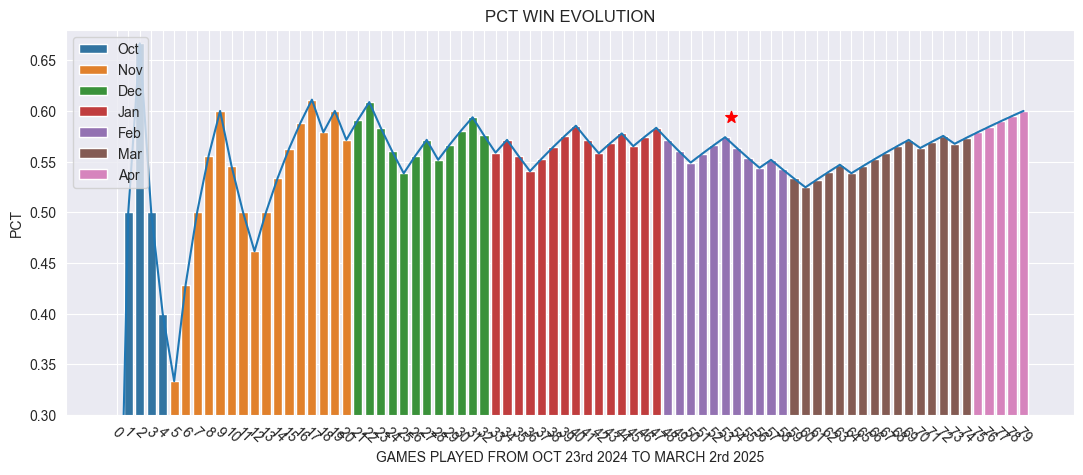

In [9]:
plt.figure(figsize=(13, 5))

sns.barplot(x="GAME_DATE",y="PCT",hue="GAME_MONTH",data=gamesData, legend=True)
sns.lineplot(x= [i for i in range(len(gamesData))],y="PCT",data=gamesData)


plt.ylim(0.3,0.68)
plt.gca().set_xticklabels([i for i in range(len(gamesData))])
plt.xticks(rotation=-45)
plt.title('PCT WIN EVOLUTION')

# We mark All-Star break
plt.scatter(53.5, gamesData[gamesData['GAME_DATE']=='2025-02-13']['PCT']  + 0.02, color='red', marker='*', s=75)
plt.xlabel('GAMES PLAYED FROM OCT 23rd 2024 TO MARCH 2rd 2025')
plt.grid(True)
plt.show()

# 2. Points Scored (Wins vs Losses)

In [10]:
gamesData['GAME_COLOR'] = gamesData['WL'].map(color_mapping)

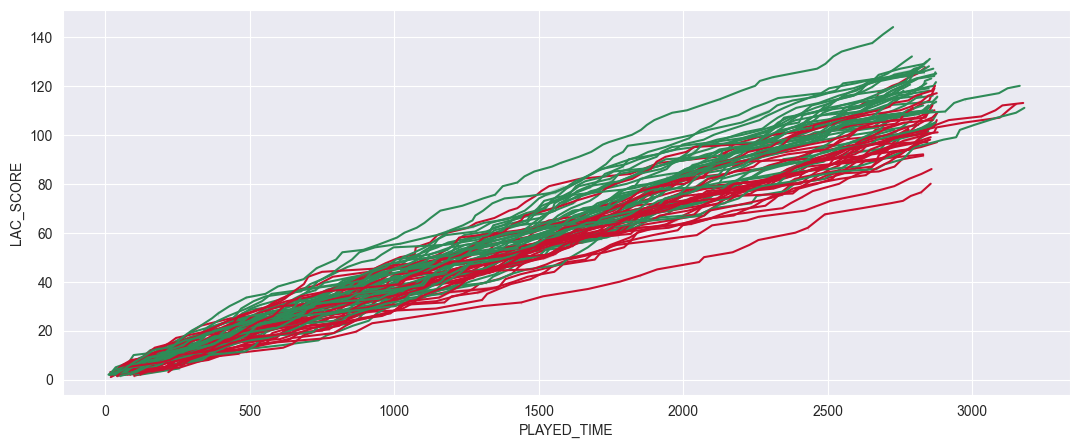

In [11]:
plt.figure(figsize=(13, 5))

game_colors = dict(zip(gamesData['GAME_ID'], gamesData['GAME_COLOR']))

sns.lineplot(playsData, x="PLAYED_TIME",y="LAC_SCORE",hue="GAME_ID", palette=game_colors,legend=False)
plt.grid(True)

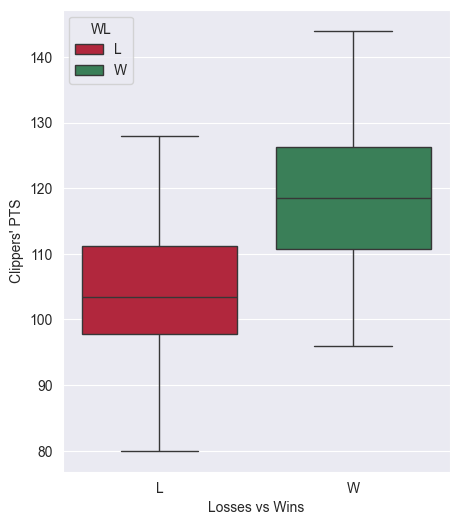

In [12]:
plt.figure(figsize=(5,6))

# We generate a boxplot to compare Wins vs Losses results.
sns.boxplot(data=gamesData, x="WL", y="LAC_PTS",hue="WL",palette=color_mapping,legend=True)
plt.title('')
plt.ylabel("Clippers' PTS")
plt.xlabel('Losses vs Wins')
plt.show()

### 2.2 +/- for each quarter

In [13]:
plays = pd.read_csv('../ClippersGamesPlays.csv',index_col=0)
plays['SCOREMARGIN'] = plays['SCOREMARGIN'].apply(lambda x: 0 if x=="TIE" else int(x))

In [14]:
plays

,Unnamed: 0,GAME_ID,EVENTMSGTYPE,PERIOD,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,SCORE,SCOREMARGIN,PLAYED_TIME
0,14.0,22401036,1,1,10:37,NaN,NaN,Hartenstein 1' Cutting Dunk Shot (2 PTS) (Gilg...,2 - 0,-2,0:01:23
1,21.0,22401036,1,1,9:58,Zubac Putback Dunk (2 PTS),NaN,NaN,2 - 2,0,0:02:02
2,22.0,22401036,1,1,9:50,NaN,NaN,Hartenstein 2' Cutting Layup Shot (4 PTS) (Gil...,4 - 2,-2,0:02:10
3,23.0,22401036,1,1,9:30,Zubac 3' Driving Reverse Layup (4 PTS),NaN,NaN,4 - 4,0,0:02:30
4,32.0,22401036,1,1,8:10,NaN,NaN,Wallace 26' 3PT Jump Shot (3 PTS) (Hartenstein...,7 - 4,-3,0:03:50
...,...,...,...,...,...,...,...,...,...,...,...
381,NaN,22401166,1,4,2:38,Harden 2' Driving Floating Jump Shot (32 PTS) ...,NaN,NaN,115 - 128,13,0:45:22
382,NaN,22401166,1,4,2:24,NaN,NaN,Williams 4' Driving Floating Jump Shot (4 PTS),117 - 128,11,0:45:36
387,NaN,22401166,1,4,1:30,Harden 25' 3PT Step Back Jump Shot (35 PTS),NaN,NaN,117 - 131,14,0:46:30
393,NaN,22401166,1,4,1:02,Bogdanović 28' 3PT Jump Shot (16 PTS) (Zubac 1...,NaN,NaN,117 - 134,17,0:46:58


In [15]:
netRatingGames = pd.DataFrame(columns=["GAME_ID","PERIOD","INITIAL_SCORE","END_SCORE","NET_RATING_PERIOD"])

def calculateNetRating(quarter,plays):
    netRating = []
    
    for game in plays['GAME_ID'].unique():
        endQuarterScore = plays[(plays['GAME_ID']==game) & (plays['PERIOD']==quarter)].iloc[-1]['SCORE']
        scores = endQuarterScore.split('-')

        if gamesData[gamesData['GAME_ID']==game]['HA'].values == 'H':
            ClippersScore = int(scores[1])
            OppScore = int(scores[0])
        else:
            ClippersScore = int(scores[0])
            OppScore = int(scores[1])
        
        if quarter > 1:
            previousQuarter = netRatingGames[(netRatingGames["PERIOD"]==quarter-1) & (netRatingGames["GAME_ID"]==game)]
            ClippersResetScore = ClippersScore - previousQuarter['INITIAL_SCORE'].values[0]
            OppResetScore = OppScore - previousQuarter['END_SCORE'].values[0]

            scoreMargin = ClippersResetScore - OppResetScore

        else:
            scoreMargin = ClippersScore - OppScore
        
        data = [game, quarter, ClippersScore, OppScore, scoreMargin]
        netRatingGames.loc[len(netRatingGames)] = data

for i in range(1,5): calculateNetRating(i,plays)

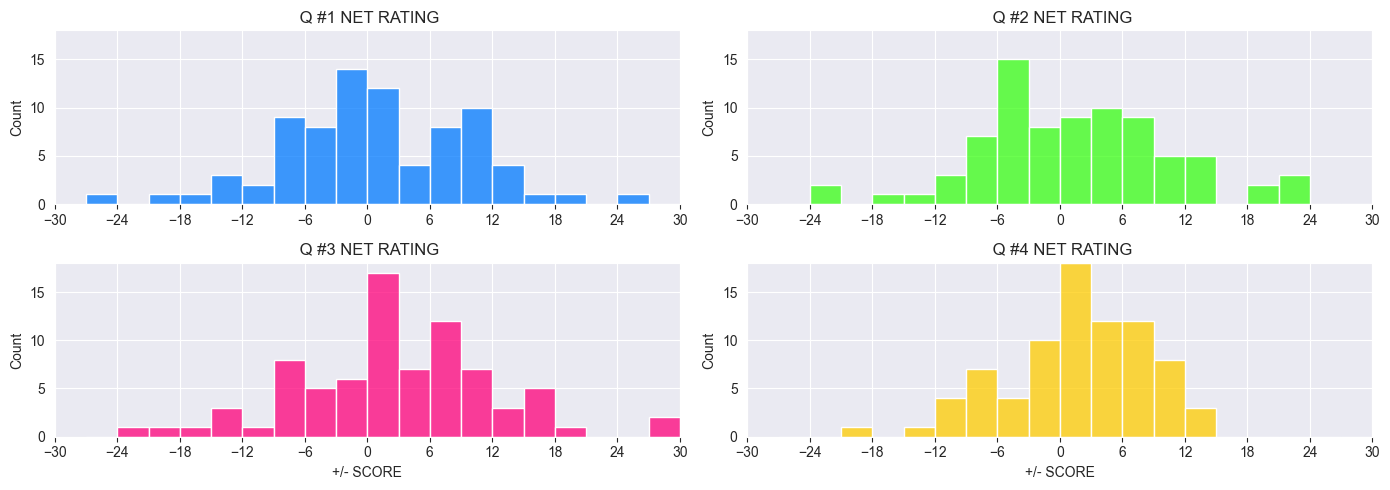

In [ ]:
gameColumns = ['GAME_ID','GAME_DATE','MATCHUP','WL','PLUS_MINUS']
result = pd.merge(left=netRatingGames,right=gamesData[gameColumns],on="GAME_ID")

colors = [
    (0/255, 122/255, 255/255),    
    (57/255, 255/255, 20/255),    
    (255/255, 0/255, 122/255),    
    (255/255, 204/255, 0/255)     
]

fig, axes = plt.subplots(2, 2, sharex=True, figsize=(14,5))

x_min, x_max = result['NET_RATING_PERIOD'].min(), result['NET_RATING_PERIOD'].max()

bin_width = 3
neg_bins = np.arange(np.floor(x_min / bin_width) * bin_width, 0, bin_width)  
pos_bins = np.arange(0, np.ceil(x_max / bin_width) * bin_width + bin_width, bin_width) 
bins = np.concatenate([neg_bins, pos_bins])

y_max = 0
for i in range(1, 5):
    hist_data = result[result['PERIOD'] == i]['NET_RATING_PERIOD']
    hist, _ = np.histogram(hist_data, bins=bins)
    y_max = max(y_max, hist.max()) 

for i in range(1,5):
    row, col = divmod(i - 1, 2)
    
    sns.histplot(ax=axes[row, col], data=result[result['PERIOD']==i],x="NET_RATING_PERIOD",bins=bins, color=colors[i-1])

    mean = np.mean(result[result['PERIOD']==i]['NET_RATING_PERIOD'])
    
    axes[row, col].set_title(f" Q #{i} NET RATING")
    axes[row, col].tick_params(axis='x', which='both', bottom=True, labelbottom=True)  
    axes[row, col].set_xlim(x_min, x_max) 
    axes[row, col].set_ylim(0, y_max) 
    axes[row,col].set_xlabel("+/- SCORE")

    x_ticks = np.arange(np.floor(x_min / 6) * 6, np.ceil(x_max / 6) * 6 + 6, 6)
    axes[row, col].set_xticks(x_ticks)


plt.tight_layout()
plt.show()
    

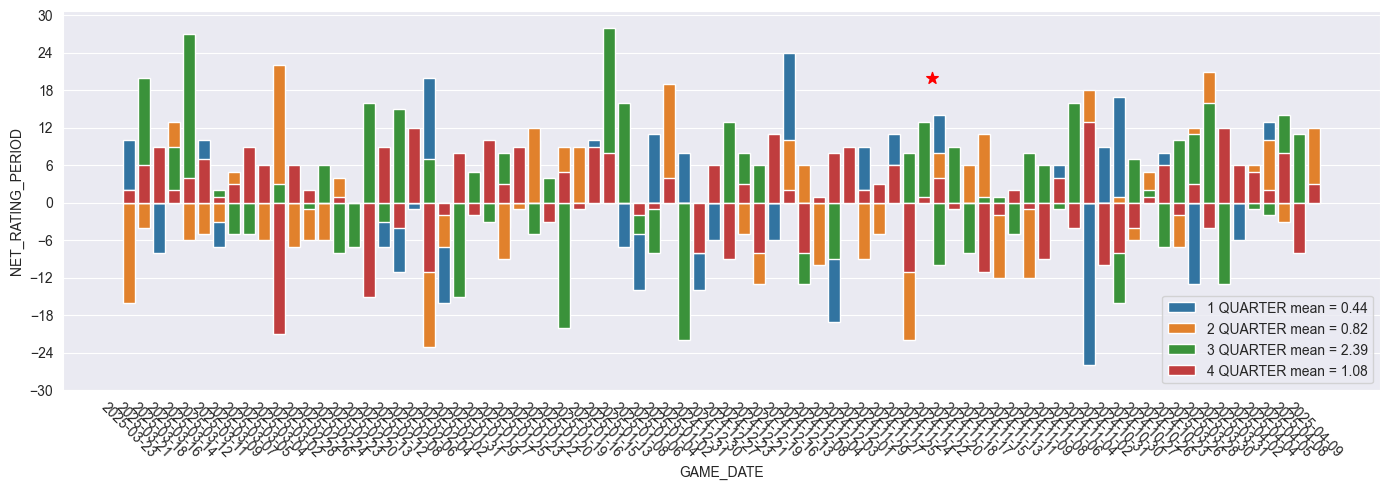

In [18]:
plt.figure(figsize=(14, 5))

for i in range(1,5):
    data = result[result['PERIOD']==i]
    mean = round(np.mean(data['NET_RATING_PERIOD']),2)

    sns.barplot(data=data,x="GAME_DATE",y="NET_RATING_PERIOD", label=f"{i} QUARTER mean = {mean}")


# We mark All-Star break
plt.scatter(53.5, 20, color='red', marker='*', s=75)

y_ticks = np.arange(np.floor(x_min / 5) * 5, np.ceil(x_max / 5) * 5 + 5, 5)
plt.yticks(x_ticks)
plt.xticks()

plt.xticks(rotation=-45)
plt.tight_layout()
plt.show()

# 3. Players Performance

In [ ]:
def extractPlay(HOME,VISITOR): return VISITOR if pd.isna(HOME) else HOME

playsData['LAC_PLAYS'] = playsData.apply(lambda x: extractPlay(x['HOMEDESCRIPTION'] , x['VISITORDESCRIPTION']),axis=1)
playsData['SCOREMARGIN'] = playsData['SCOREMARGIN'].apply(lambda x: 0 if x=="TIE" else int(x))
HardenSM = playsData[playsData['LAC_PLAYS'].str.split(' ').apply(lambda x: x[0]=='Harden')]
LeonardSM = playsData[playsData['LAC_PLAYS'].str.split(' ').apply(lambda x: x[0]=='Leonard')]
PowellSM = playsData[playsData['LAC_PLAYS'].str.split(' ').apply(lambda x: x[0]=='Powell')]

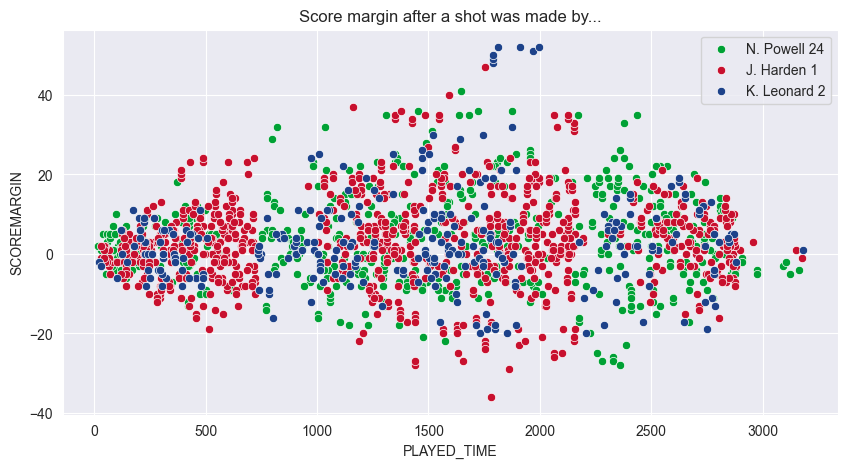

In [ ]:
plt.figure(figsize=(10, 5))

sns.scatterplot(data=PowellSM,x="PLAYED_TIME",y="SCOREMARGIN",label="N. Powell 24",color="#00a135")
sns.scatterplot(data=HardenSM,x="PLAYED_TIME",y="SCOREMARGIN",label="J. Harden 1",color="#c8102E")
sns.scatterplot(data=LeonardSM,x="PLAYED_TIME",y="SCOREMARGIN",label="K. Leonard 2",color="#1d428a")
plt.title("Score margin after a shot was made by...")
plt.legend()

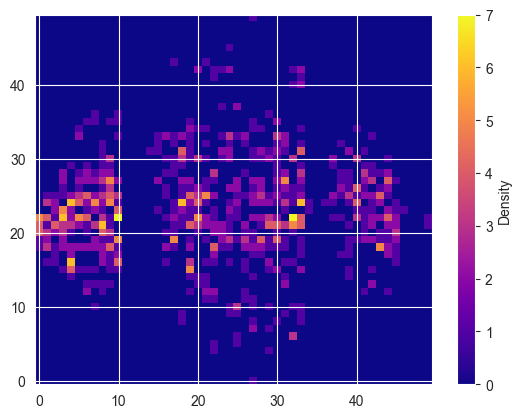

In [ ]:
import numpy as np

heatmap, xedges,yedges = np.histogram2d(HardenSM["PLAYED_TIME"],HardenSM["SCOREMARGIN"], bins=50)
plt.imshow(heatmap.T, origin='lower',cmap='plasma',aspect='auto')
plt.colorbar(label='Density')

[96.5, 99.5, 102.5, 105.5, 108.5, 111.5, 114.5, 117.5, 120.5, 123.5, 126.5]


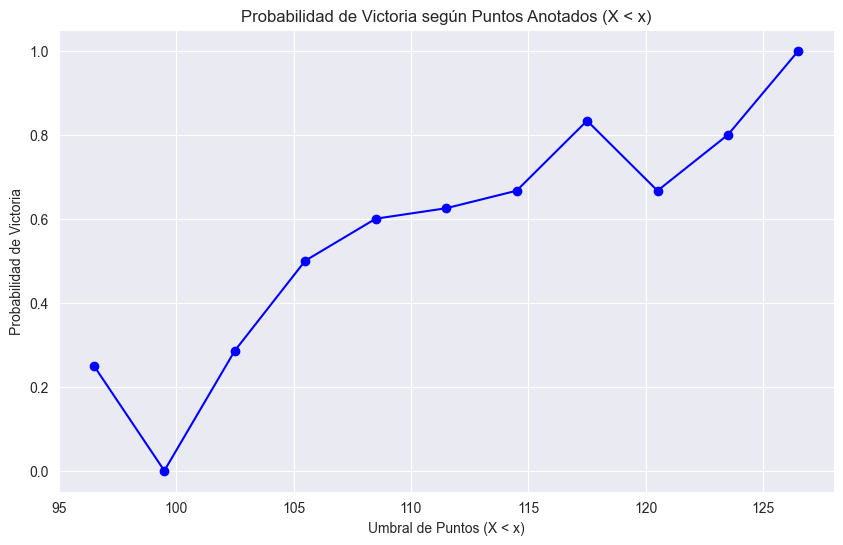

In [ ]:

def probWBasedOnLACPTS(min,max,step,data):
    thresholds = [x for x in range(min,max,step)]
    
    probabilities = []

    for thresh in range(len(thresholds)):
        if thresh+1 < len(thresholds):
            LAC_PTS = data[(data['LAC_PTS']>=thresholds[thresh]) & (data['LAC_PTS']<thresholds[thresh+1])]
            prob = len(LAC_PTS[LAC_PTS['WL']=='W'])/len(LAC_PTS)

            probabilities.append(prob)

    print(thresholds)
    thresholds = [x + 1.5 for x in thresholds[:-1]]
    
    prob_df = pd.DataFrame({'threshold': thresholds, 'probability': probabilities})

    return prob_df

prob_df = probWBasedOnLACPTS(95,130,3,gamesData)

plt.figure(figsize=(10, 6))
plt.plot(prob_df['threshold'], prob_df['probability'], marker='o', color='b')
plt.title('Probabilidad de Victoria según Puntos Anotados (X < x)')
plt.xlabel('Umbral de Puntos (X < x)')
plt.ylabel('Probabilidad de Victoria')
plt.grid(True)
plt.show()